# Pricing Optimisation & Revenue Simulation

In this notebook, I use the estimated price elasticity from the previous analysis
to simulate **what-if pricing scenarios** and identify **price changes that
maximize revenue** for SunnyBest.

This analysis answers practical business questions such as:
- What happens to revenue if prices increase or decrease by X%?
- Which categories benefit most from price reductions?
- Where should SunnyBest avoid discounting?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


**Assumption:**  
We use the merged dataset created earlier (`df`) which already contains:
- units_sold
- price
- revenue
- category
- season


In [4]:
df = pd.read_csv("../data/processed/sunnybest_merged_df.csv", parse_dates=["date"], low_memory=False)
df.head()

,date,store_id,product_id,units_sold,price,regular_price,discount_pct,promo_flag,promo_type,revenue,...,is_weekend,is_holiday,is_payday,season,temperature_c,rainfall_mm,weather_condition,promo_type_promo,discount_pct_promo,promo_flag_promo
0,2021-01-01,1,1001,0,445838.0,445838,0,0,NaN,0.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN
1,2021-01-01,1,1002,2,500410.0,500410,0,0,NaN,1000820.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN
2,2021-01-01,1,1003,2,399365.0,399365,0,0,NaN,798730.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN
3,2021-01-01,1,1004,4,305796.0,305796,0,0,NaN,1223184.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN
4,2021-01-01,1,1005,5,462752.0,462752,0,0,NaN,2313760.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,NaN,NaN


In [6]:
#sanity check
df[["units_sold", "price", "revenue", "season"]].head(3)

,units_sold,price,revenue,season
0,0,445838.0,0.0,Dry
1,2,500410.0,1000820.0,Dry
2,2,399365.0,798730.0,Dry


In [7]:
pricing_df = (
    df.groupby("category")
      .agg(
          avg_price=("price", "mean"),
          avg_units=("units_sold", "mean"),
          avg_revenue=("revenue", "mean")
      )
      .reset_index()
)

pricing_df


,category,avg_price,avg_units,avg_revenue
0,Accessories,20912.503018,4.584942,96274.163354
1,Air Conditioners,584182.840665,0.174952,104146.976991
2,Laptops & Computers,535339.408878,0.654289,342653.230056
3,Mobile Phones,342961.919576,1.771228,596735.913372
4,Network Devices,87034.184790,1.060828,91316.876465
5,Refrigerators,399776.838887,0.195536,83704.325548
6,Small Appliances,48606.937243,2.238317,107936.923154
7,Telecom Services,11385.329826,19.507676,215107.635953
8,Televisions,497358.575262,0.462032,226570.941155


## Pricing Optimisation Logic

Using constant elasticity demand:

Demand_new = Demand_old × (Price_new / Price_old) ^ elasticity

Revenue_new = Price_new × Demand_new

We simulate price changes from **-30% to +30%** and observe
how revenue responds.


In [10]:
# recompute elasticity in this notebook

elastic_df = df[(df["units_sold"] > 0) & (df["price"] > 0)].copy()
def fit_elasticity(group: pd.DataFrame) -> float:
    g = group[(group["units_sold"] > 0) & (group["price"] > 0)].copy()
    if len(g) < 200:
        return np.nan

    g["log_units"] = np.log(g["units_sold"])
    g["log_price"] = np.log(g["price"])
    g["discount_rate"] = g["discount_pct"] / 100.0

    X = np.column_stack([
        np.ones(len(g)),
        g["log_price"].values,
        g["discount_rate"].values,
        g["is_weekend"].astype(int).values,
        g["is_holiday"].astype(int).values,
        g["is_payday"].astype(int).values
    ])
    y = g["log_units"].values

    b = np.linalg.lstsq(X, y, rcond=None)[0]
    return float(b[1])  # elasticity
elasticity_by_cat = (
    elastic_df.groupby("category")
    .apply(fit_elasticity)
    .reset_index(name="price_elasticity")
)


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_83809/420319436.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_elasticity)


In [11]:
# Attach Elasticities
pricing_df = pricing_df.merge(
    elasticity_by_cat,
    on="category",
    how="left"
)

pricing_df


,category,avg_price,avg_units,avg_revenue,price_elasticity
0,Accessories,20912.503018,4.584942,96274.163354,-0.028093
1,Air Conditioners,584182.840665,0.174952,104146.976991,0.003359
2,Laptops & Computers,535339.408878,0.654289,342653.230056,-0.011426
3,Mobile Phones,342961.919576,1.771228,596735.913372,-0.096484
4,Network Devices,87034.184790,1.060828,91316.876465,-0.054735
5,Refrigerators,399776.838887,0.195536,83704.325548,0.003021
6,Small Appliances,48606.937243,2.238317,107936.923154,-0.053848
7,Telecom Services,11385.329826,19.507676,215107.635953,-0.088784
8,Televisions,497358.575262,0.462032,226570.941155,0.017835


In [12]:
# revenue simulation function
def simulate_revenue(price, units, elasticity, pct_change):
    new_price = price * (1 + pct_change)
    new_units = units * (new_price / price) ** elasticity
    return new_price * new_units


In [13]:
# Run Price Scenarios
price_changes = np.linspace(-0.3, 0.3, 25)

simulation_results = []

for _, row in pricing_df.iterrows():
    for pct in price_changes:
        revenue_sim = simulate_revenue(
            row["avg_price"],
            row["avg_units"],
            row["price_elasticity"],
            pct
        )
        simulation_results.append({
            "category": row["category"],
            "price_change_pct": pct,
            "simulated_revenue": revenue_sim
        })

sim_df = pd.DataFrame(simulation_results)


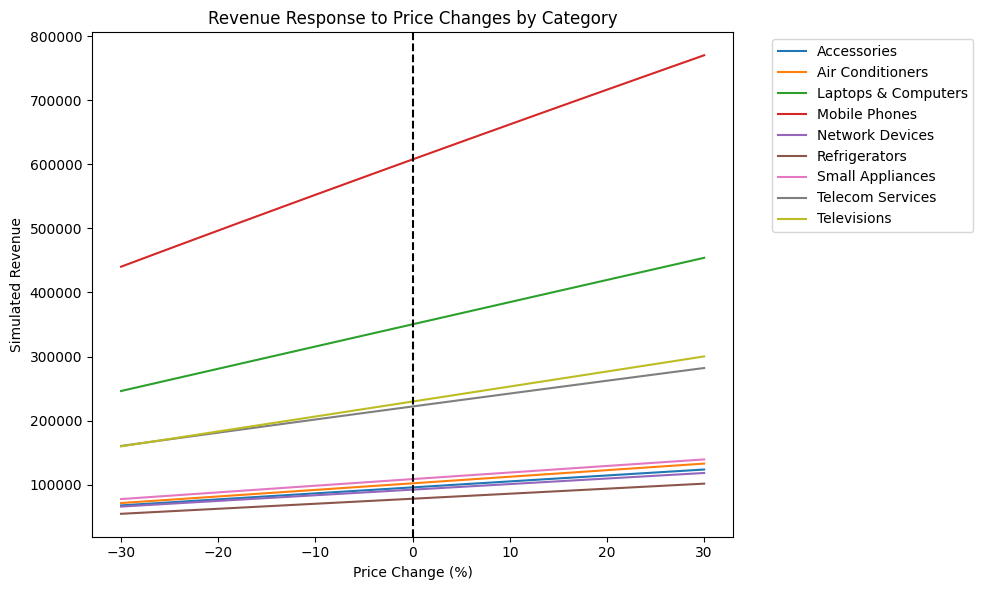

In [14]:
# Visualize Revenue Curves
plt.figure(figsize=(10, 6))

for cat in sim_df["category"].unique():
    subset = sim_df[sim_df["category"] == cat]
    plt.plot(
        subset["price_change_pct"] * 100,
        subset["simulated_revenue"],
        label=cat
    )

plt.axvline(0, linestyle="--", color="black")
plt.xlabel("Price Change (%)")
plt.ylabel("Simulated Revenue")
plt.title("Revenue Response to Price Changes by Category")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Optimal Pricing Points

The optimal price for each category is the price change that maximizes revenue.


In [15]:
# Identify Optimal Price Change
optimal_prices = (
    sim_df
    .sort_values("simulated_revenue", ascending=False)
    .groupby("category")
    .first()
    .reset_index()
)

optimal_prices["optimal_price_change_pct"] = optimal_prices["price_change_pct"] * 100

optimal_prices[["category", "optimal_price_change_pct"]]


,category,optimal_price_change_pct
0,Accessories,30.0
1,Air Conditioners,30.0
2,Laptops & Computers,30.0
3,Mobile Phones,30.0
4,Network Devices,30.0
5,Refrigerators,30.0
6,Small Appliances,30.0
7,Telecom Services,30.0
8,Televisions,30.0


## Business Interpretation
The pricing simulation shows that, across most product categories, demand is relatively price inelastic within the tested range (−30% to +30%).

As a result:
- Moderate price increases lead to higher total revenue for several categories, including Mobile Phones, Laptops & Computers, and Televisions.
- Categories with flatter revenue curves (e.g. Accessories, Small Appliances) show limited sensitivity to price changes, indicating stable demand.
- This suggests that SunnyBest may currently be underpricing certain products, especially in high-demand categories.

Importantly, these results hold within the simulated range and assume no competitive response. In practice, pricing decisions should be combined with market intelligence, competitor monitoring, and customer retention considerations.

## Strategic Recommendations
SunnyBest should adopt category-specific pricing strategies rather than blanket promotions.

In particular:
- Apply controlled price increases in relatively inelastic, high-demand categories.
- Maintain stable pricing in categories with flat revenue responses.
- Combine pricing adjustments with inventory and stockout risk monitoring.
